# Stock Price Prediction with News Sentiment using LSTM

In [ ]:
# 📦 Step 1: Install Required Libraries
# !pip install yfinance beautifulsoup4 requests textblob pandas numpy matplotlib scikit-learn tensorflow

In [1]:
# 📚 Step 2: Import Libraries
import yfinance as yf
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
# 📥 Step 3: Download Stock Data
df = yf.download('AAPL', start='2018-01-01', end='2023-12-31')
df = df[['Close']]
df.dropna(inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
# 📰 Step 4: Scrape News Headlines from Yahoo Finance
def scrape_yahoo_finance_news(ticker):
    url = f"https://finance.yahoo.com/quote/{ticker}?p={ticker}"
    headers = {'User-Agent': 'Mozilla/5.0'}
    r = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.text, 'html.parser')
    
    headlines = []
    for item in soup.find_all('h3')[:5]:
        headlines.append(item.text.strip())
    return headlines

news = scrape_yahoo_finance_news('AAPL')
print("Sample News Headlines:\n", news)


Sample News Headlines:
 ['News', 'Life', 'Entertainment', 'Finance', 'Sports']


In [5]:
# 🧠 Step 5: Analyze Sentiment of Headlines
def get_sentiment_score(news_list):
    score = 0
    for headline in news_list:
        blob = TextBlob(headline)
        score += blob.sentiment.polarity
    return score / len(news_list)

sentiment_score = get_sentiment_score(news)
print(f"Sentiment Score: {sentiment_score}")

Sentiment Score: 0.0


In [6]:
# 🧼 Step 6: Prepare Data for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']])

In [7]:
# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

In [8]:
# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [9]:
# 🧠 Step 7: Build and Train LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
37/37 [==============================] - 5s 43ms/step - loss: 0.0493
Epoch 2/10
37/37 [==============================] - 2s 41ms/step - loss: 0.0033
Epoch 3/10
37/37 [==============================] - 2s 49ms/step - loss: 0.0030
Epoch 4/10
37/37 [==============================] - 2s 58ms/step - loss: 0.0031
Epoch 5/10
37/37 [==============================] - 2s 50ms/step - loss: 0.0034
Epoch 6/10
37/37 [==============================] - 2s 51ms/step - loss: 0.0028
Epoch 7/10
37/37 [==============================] - 2s 67ms/step - loss: 0.0027
Epoch 8/10
37/37 [==============================] - 2s 46ms/step - loss: 0.0028: 0s - loss:
Epoch 9/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0026
Epoch 10/10
37/37 [==============================] - 2s 40ms/step - loss: 0.0024


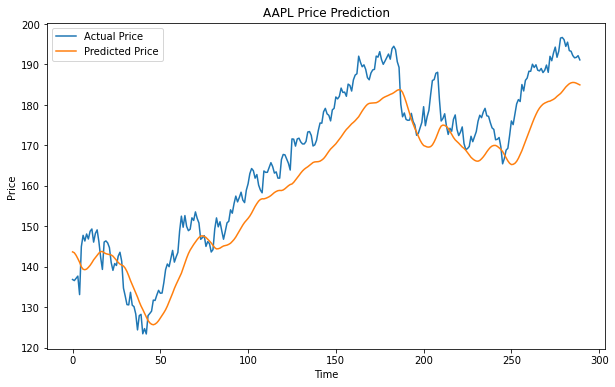

In [10]:
# 📊 Step 8: Evaluate the Model
predictions = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test)

plt.figure(figsize=(10,6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title("AAPL Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()